# Flights delays for three new york airports

In [1]:
import pandas as pd
import numpy as np
import geopandas
from matplotlib import pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import folium

In [2]:
# read in data

flights_all = pd.read_csv('../data/clean_data/flights_data.csv', index_col=0)

In [3]:
flights_all.columns

Index(['month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay', 'arr_time',
       'sched_arr_time', 'arr_delay', 'carrier', 'flight', 'tailnum', 'origin',
       'dest', 'air_time', 'distance', 'hour', 'minute', 'time_hour',
       'dep_delay_true', 'wind_dir', 'wind_speed', 'wind_gust', 'visib',
       'temp_max', 'temp_min', 'temp_ave', 'temp_departure', 'ppt', 'new_snow',
       'snow_depth', 'ori_faa', 'ori_airport', 'ori_lat', 'ori_lon', 'ori_alt',
       'ori_timezone', 'dest_faa', 'dest_airport', 'dest_lat', 'dest_lon',
       'dest_alt', 'dest_timezone', 'carrier_name', 'type', 'manufacturer',
       'model', 'engine'],
      dtype='object')

In [4]:
flights_all.head()

month  day  dep_time  sched_dep_time  dep_delay  arr_time  sched_arr_time  \
0      1    1     547.0             505       42.0     825.0             751   
1      1    1     545.0             545        0.0     833.0             831   
2      1    1     556.0             555        1.0     709.0             714   
3      1    1    1456.0             533      563.0    1757.0             843   
4      1    1     544.0             549       -5.0     847.0             858   

   arr_delay carrier  flight  ...                             dest_airport  \
0       34.0      B6    1983  ...            Orlando International Airport   
1        2.0      B6     527  ...            Orlando International Airport   
2       -5.0      UA     320  ...  Washington Dulles International Airport   
3      554.0      AA    1166  ...              Miami International Airport   
4      -11.0      AA    1399  ...              Miami International Airport   

    dest_lat   dest_lon  dest_alt     dest_timezone            carrier_name  \
0  28.429399 -81.308998      96.0  America/New_York         JetBlue Airways   
1  28.429399 -81.308998      96.0  America/New_York         JetBlue Airways   
2  38.944500 -77.455803     312.0  America/New_York   United Air Lines Inc.   
3  25.793200 -80.290604       8.0  America/New_York  American Airlines Inc.   
4  25.793200 -80.290604       8.0  America/New_York  American Airlines Inc.   

                      type      manufacturer          model     engine  
0  Fixed wing multi engine          DASSAULT  FALCON 900 EX  Turbo-fan  
1  Fixed wing multi engine            AIRBUS       A320-232  Turbo-fan  
2  Fixed wing multi engine  AIRBUS INDUSTRIE       A320-232  Turbo-fan  
3                  Unknown           Unknown        Unknown    Unknown  
4                  Unknown           Unknown        Unknown    Unknown  

[5 rows x 47 columns]

In [5]:
# split out EWR only

ewr_flights = flights_all.loc[(flights_all['origin'] == 'EWR')].copy()

In [6]:
ewr_flights.shape

(112447, 47)

If add the profiling report from the other markdown - can see that 24% of all flights in 2017 were delayed. 76% of all flights were on time.

In [7]:
ewr_geospatial = ewr_flights.loc[:, ['time_hour', 'month', 'hour',
'origin', 'dep_delay', 'dep_delay_true', 'ori_lat', 'ori_lon', 'dest',
 'dest_lat', 'dest_lon', 'visib', 'temp_ave',
  'temp_departure', 'new_snow', 'snow_depth']]

all_geospatial = flights_all.loc[:, ['time_hour', 'month', 'hour',
'origin', 'dep_delay', 'dep_delay_true', 'ori_lat', 'ori_lon', 'dest',
 'dest_lat', 'dest_lon', 'visib', 'temp_ave',
  'temp_departure', 'new_snow', 'snow_depth']]

In [8]:
pp.ProfileReport(ewr_geospatial)

Render HTML: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


In [9]:
ewr_geospatial.shape

(112447, 16)

In [10]:
ewr_geospatial.dropna(inplace = True)
all_geospatial.dropna(inplace = True)

In [11]:
ewr_geospatial.loc[:, 'dep_delay_count'] = ewr_geospatial.groupby(['origin', 'month']).dep_delay_true.transform('sum')
all_geospatial.loc[:, 'dep_delay_count'] = all_geospatial.groupby(['origin', 'month']).dep_delay_true.transform('sum')

In [12]:
ewr_geospatial.loc[:, 'total_flight_count'] = ewr_geospatial.groupby(['origin', 'month']).dep_delay.transform('count')
all_geospatial.loc[:, 'total_flight_count'] = all_geospatial.groupby(['origin', 'month']).dep_delay.transform('count')

In [13]:
ewr_geospatial.loc[:, 'percent_delay'] = (ewr_geospatial.dep_delay_count / ewr_geospatial.total_flight_count) * 100
all_geospatial.loc[:, 'percent_delay'] = (all_geospatial.dep_delay_count / all_geospatial.total_flight_count) * 100

In [14]:
ewr_geospatial.head()

time_hour  month  hour origin  dep_delay  dep_delay_true  \
1   2017-01-01T05:00:00Z      1     5    EWR        0.0           False   
2   2017-01-01T05:00:00Z      1     5    EWR        1.0           False   
13  2017-01-01T06:00:00Z      1     6    EWR       -1.0           False   
14  2017-01-01T06:00:00Z      1     6    EWR       -3.0           False   
20  2017-01-01T06:00:00Z      1     6    EWR       36.0            True   

      ori_lat    ori_lon dest   dest_lat   dest_lon  visib  temp_ave  \
1   40.692501 -74.168701  MCO  28.429399 -81.308998   10.0      41.5   
2   40.692501 -74.168701  IAD  38.944500 -77.455803   10.0      41.5   
13  40.692501 -74.168701  MIA  25.793200 -80.290604   10.0      41.5   
14  40.692501 -74.168701  FLL  26.072599 -80.152702   10.0      41.5   
20  40.692501 -74.168701  BOS  42.364300 -71.005203   10.0      41.5   

    temp_departure  new_snow  snow_depth  dep_delay_count  total_flight_count  \
1              7.2       0.0         0.0             2405                8845   
2              7.2       0.0         0.0             2405                8845   
13             7.2       0.0         0.0             2405                8845   
14             7.2       0.0         0.0             2405                8845   
20             7.2       0.0         0.0             2405                8845   

    percent_delay  
1       27.190503  
2       27.190503  
13      27.190503  
14      27.190503  
20      27.190503

In [15]:
# plot setting for notebook

plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10

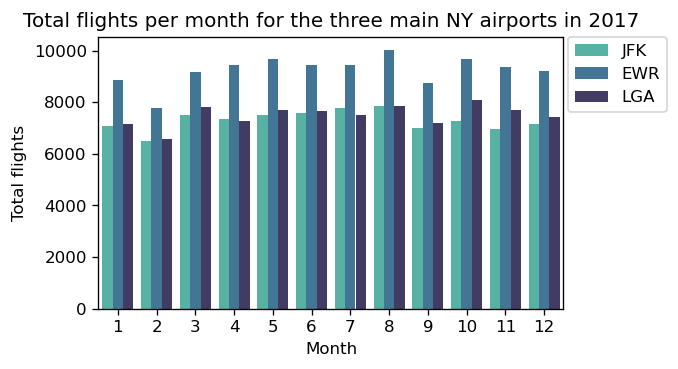

In [16]:
sns.barplot(x = 'month', y = 'total_flight_count', hue = 'origin', palette = "mako_r", data = all_geospatial)
plt.title("Total flights per month for the three main NY airports in 2017")
plt.xlabel("Month")
plt.ylabel("Total flights")
plt.legend(bbox_to_anchor=(1.01, 1), loc = 2,
           borderaxespad=0);

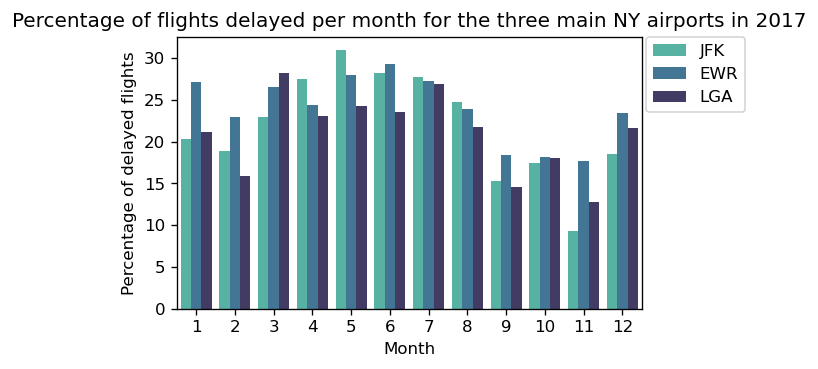

In [17]:
sns.barplot(x = 'month', y = 'percent_delay', hue = 'origin', palette = "mako_r", data = all_geospatial)
plt.title("Percentage of flights delayed per month for the three main NY airports in 2017")
plt.xlabel("Month")
plt.ylabel("Percentage of delayed flights")
plt.legend(bbox_to_anchor=(1.01, 1), loc = 2,
           borderaxespad=0);

In [18]:
# making a geopandas df for flight 'origin', 'percent_delay'

geometry = geopandas.points_from_xy(all_geospatial.ori_lon, all_geospatial.ori_lat)
geo_flights = geopandas.GeoDataFrame(all_geospatial[['origin',
 'month', 'total_flight_count', 'percent_delay', 'ori_lon', 'ori_lat']],
  geometry = geometry)

In [19]:
px_geo_flights = ewr_geospatial.loc[:, ['origin',
 'month', 'total_flight_count', 'percent_delay', 'ori_lon', 'ori_lat']]

In [20]:
import plotly.express as px

In [21]:
test_fig = px.scatter_mapbox(px_geo_flights,
lat='ori_lat',
lon='ori_lon',
hover_name='origin',
color='percent_delay',
zoom=9,
height=600,
size='percent_delay',
size_max=30,
opacity=0.4,
width=1300)

test_fig.update_layout(mapbox_style='carto-positron')
test_fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
test_fig.update_layout(title_text="percent_delay_all_months")
test_fig.show()

need total flights per destination and dep_depay count per dest to work out percent delay flights per destination as per above for per month.
do the same per airline?
Also need to think of weather. maybe check the temp deviation and visibility? and gusting winds?

In [22]:
dest_delay = ewr_geospatial.groupby(['dest']).dep_delay_true.agg('sum').reset_index().copy()



In [23]:
us_map = folium.Map(location=[40.6925, -74.1687], 
zoom_start = 7,
tiles="cartodbpositron")

In [24]:
us_map

for _, row in ewr_geospatial.iterrows():

    folium.CircleMarker([row['ori_lat'], row['ori_lon']],
                        radius=10,
                        fill_color="#3db7e4", # divvy color
                       ).add_to(us_map)

    folium.CircleMarker([row['dest_lat'], row['dest_lon']],
                        radius=10,
                        fill_color="red", # divvy color
                       ).add_to(us_map)

    folium.PolyLine([[row['ori_lat'], row['ori_lon']], 
                     [row['dest_lat'], row['dest_lon']]]).add_to(us_map)

In [25]:
us_map